In [5]:
import numpy as np
import pandas as pd

In [6]:
data = pd.read_csv("LOL_matchdata_2024.csv")
data = data.iloc[:, :-1]
data = data.dropna()
data = data.drop(columns=['DateTime UTC','Items', 'CS', 'DamageToChampions', 'GameId', 'Name', 'Age', 'Tournament'])

In [7]:

data['BaronDifference'] = np.where(
    data['Team'] == data['Team1'],
    data['Team1Barons'] - data['Team2Barons'],
    np.where(
        data['Team'] == data['Team2'],
        data['Team2Barons'] - data['Team1Barons'], np.nan))
data['TowerDifference'] = np.where(
    data['Team'] == data['Team1'],
    data['Team1Towers'] - data['Team2Towers'],
    np.where(
        data['Team'] == data['Team2'],
        data['Team2Towers'] - data['Team1Towers'],
        np.nan))
data.drop(columns=['Team1Barons', 'Team2Barons', 'Team1Towers', 'Team2Towers', 'Team1', 'Team2', 'TeamVs', 'TowerDifference'], inplace=True)

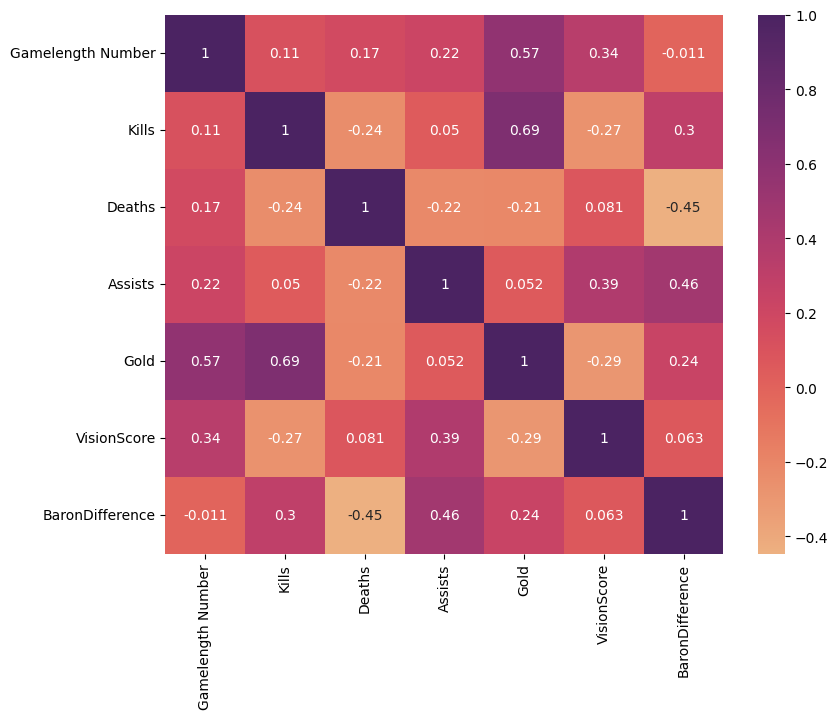

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
numeric_data = data.select_dtypes(include=np.number)
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='flare')
plt.show()

<ipython-input-9-2d0f8a95ca8b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['Role'], y=data['Kills'], palette='flare')


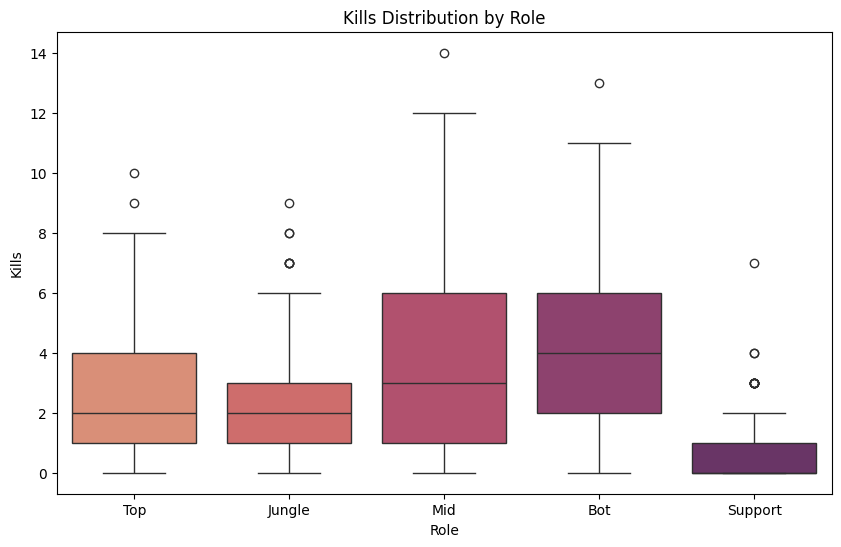

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Role'], y=data['Kills'], palette='flare')
plt.title('Kills Distribution by Role')
plt.xlabel('Role')
plt.ylabel('Kills')
plt.show()

In [10]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Separate features (X) and target (y)
target = 'Kills'
X = data.drop(columns=[target])
y = data[target]

# Identify categorical and numeric columns
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing: One-hot encoding for categorical and scaling for numeric
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop ='first'), categorical_features)
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Check if the result is sparse, and convert to dense if necessary
if hasattr(X_processed, "toarray"):  # If it's sparse
    X_processed = X_processed.toarray()

# Get column names for the transformed data
# Numeric columns remain unchanged
numeric_columns = numeric_features.tolist()

# For the one-hot encoded columns, get feature names from OneHotEncoder
categorical_columns = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features).tolist()

# Combine the column names
column_names = numeric_columns + categorical_columns

# Convert the result to a DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=column_names)

# Ensure the indices of X_processed_df and y are aligned
X_processed_df = X_processed_df.reset_index(drop=True)
y = y.reset_index(drop=True)

# Add constant to X_processed for OLS
X_processed_with_const = sm.add_constant(X_processed_df)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed_with_const, y, test_size=0.2, random_state=42)

# Ensure that the indices of X_train and y_train are aligned
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Linear regression using statsmodels
model = sm.OLS(y_train, X_train)
results = model.fit()

# Display the summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  Kills   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     21.89
Date:                Mon, 30 Dec 2024   Prob (F-statistic):          1.86e-112
Time:                        20:59:48   Log-Likelihood:                -1082.7
No. Observations:                 624   AIC:                             2289.
Df Residuals:                     562   BIC:                             2564.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [11]:
def LR_OSR2(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)  # Sum of Squared Errors
    SST = np.sum((y_test - np.mean(y_train))**2)  # Total Sum of Squares
    return (1 - SSE/SST)

# Calculate OSR² for Linear Regression
lr_osr2 = LR_OSR2(results, X_test, y_test, y_train)

# Print the OSR² for the Linear Regression model
print(f"OSR² for the Linear Regression model: {lr_osr2:.4f}")

OSR² for the Linear Regression model: 0.6752


In [12]:
# calculate Variance Inflation Factor for each explanatory variable
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

VIF(X, numeric_features)

,0
Gamelength Number,3.518042
Deaths,1.498649
Assists,1.579354
Gold,3.544281
VisionScore,2.337927
BaronDifference,1.675623


Fitting 10 folds for each of 201 candidates, totalling 2010 fits
Node count = 25


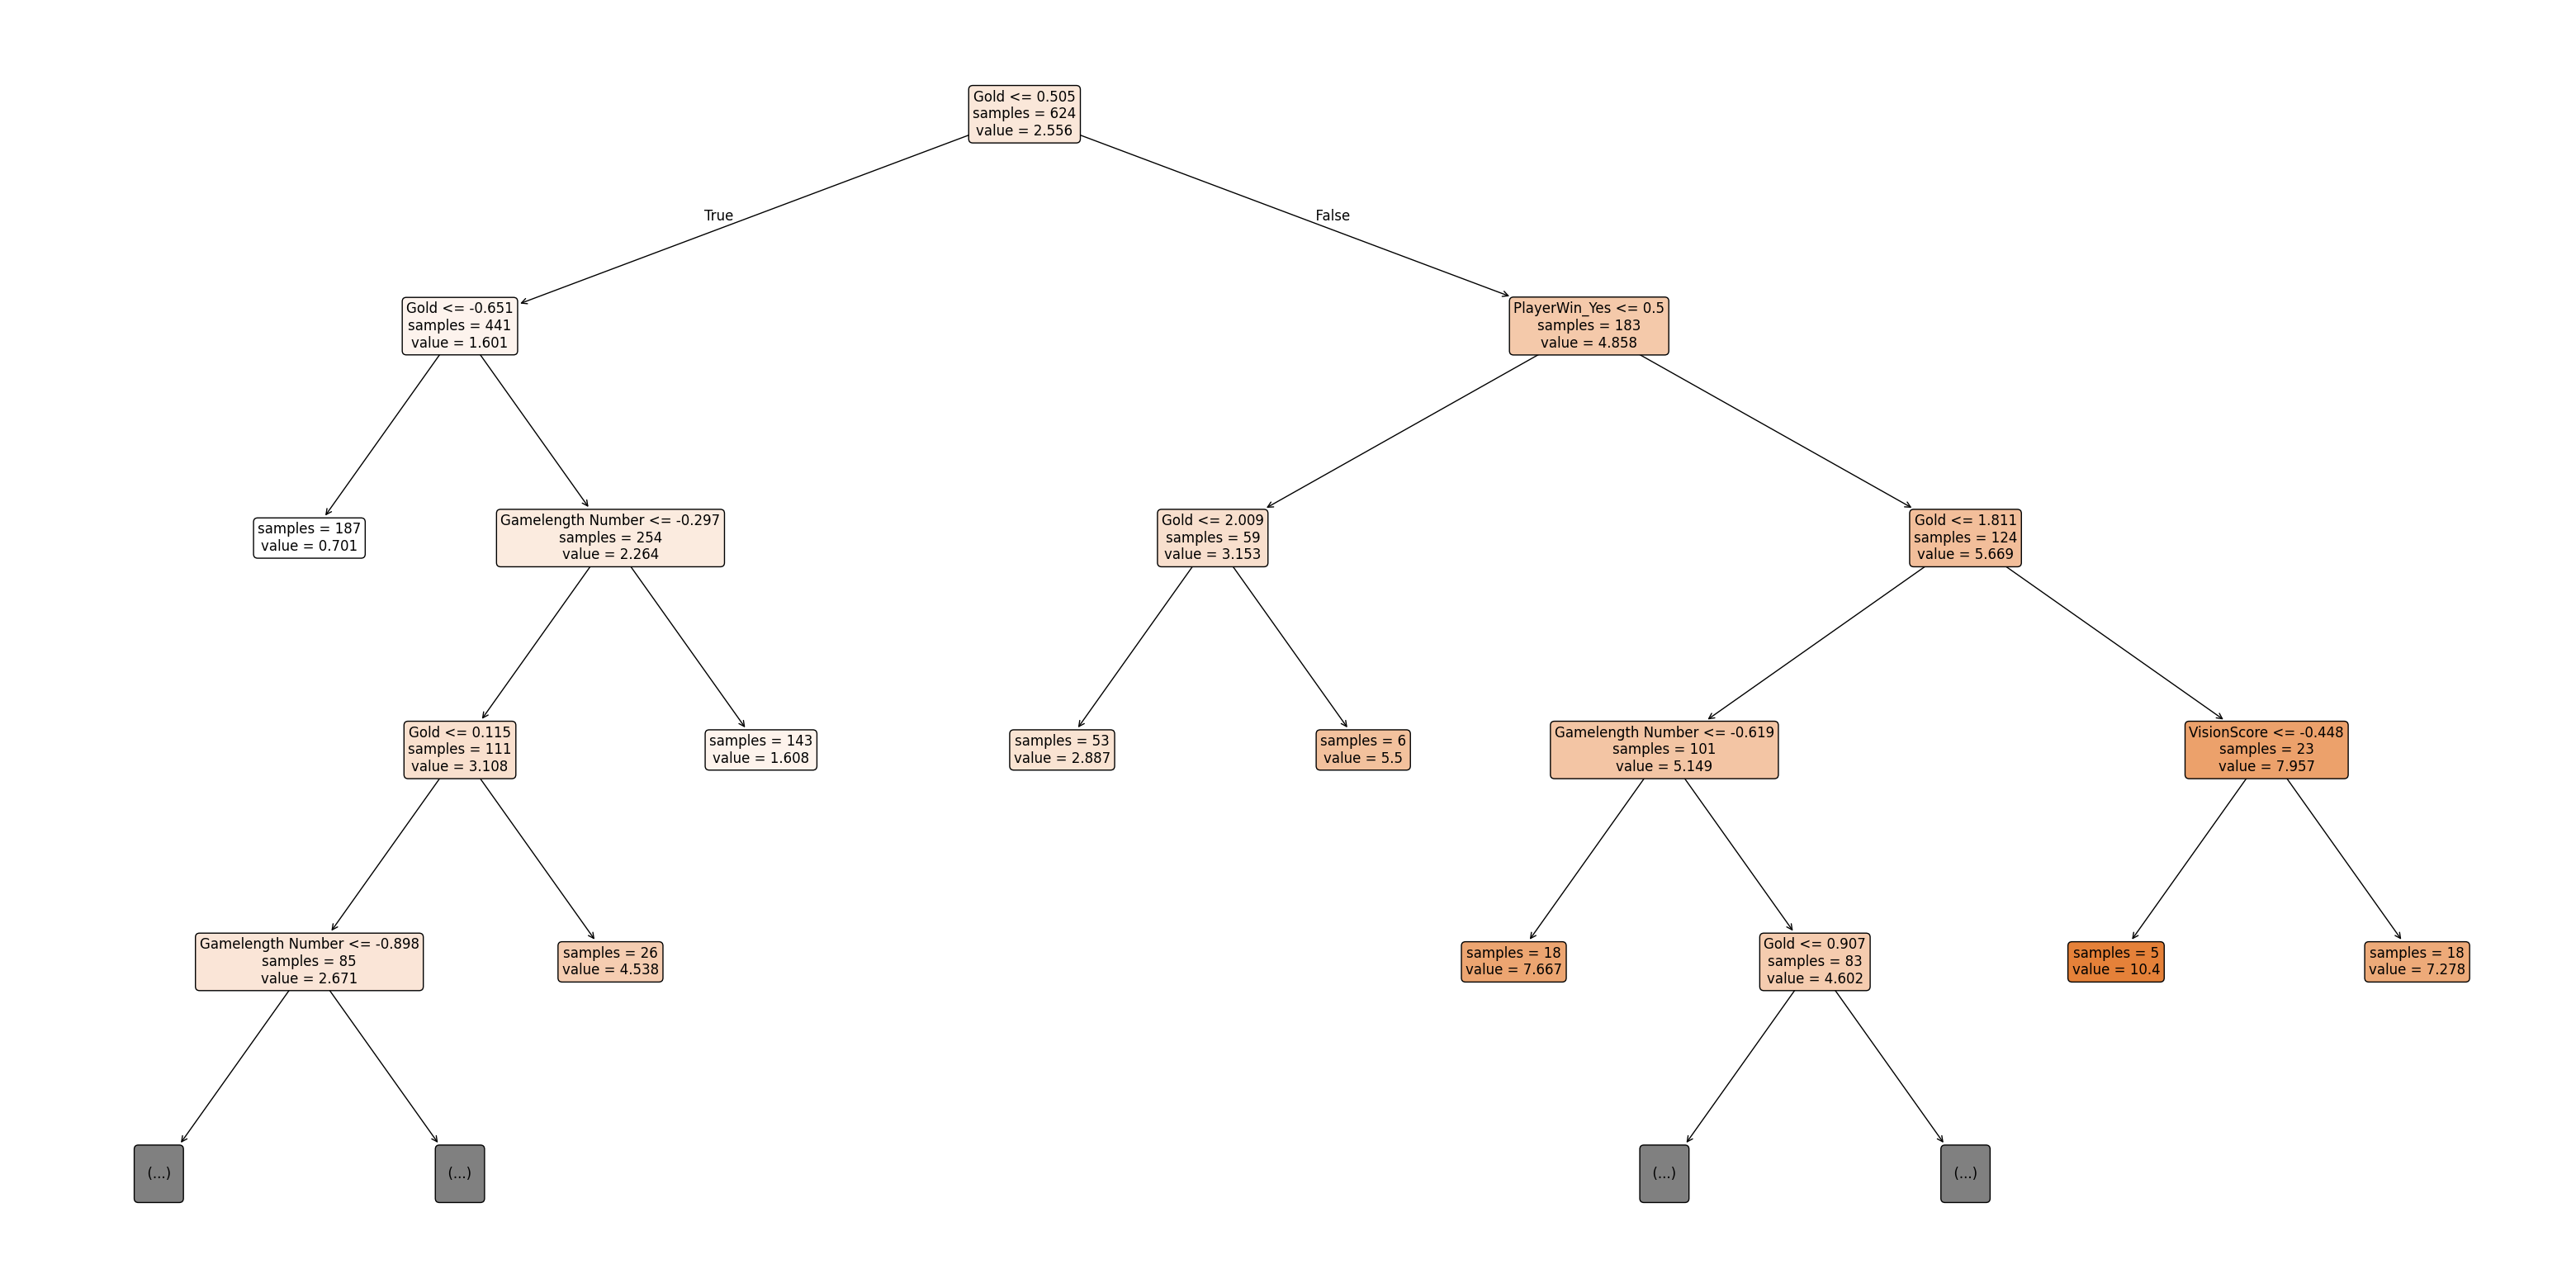

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [2024]}
dtr = DecisionTreeRegressor()
dtr_cv_nmse = GridSearchCV(dtr, param_grid = grid_values,
                           scoring='neg_mean_squared_error', cv=10, verbose=1)
dtr_cv_nmse.fit(X_train, y_train)
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
print('Node count =', dtr_cv_nmse.best_estimator_.tree_.node_count)
plt.figure(figsize=(40,20))
plot_tree(dtr_cv_nmse.best_estimator_,
          feature_names=X_train.columns,
          class_names=['0','1'],
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12,
          max_depth=4)
plt.show()

In [14]:
# CART OSR^2 Calculation
def CART_OSR2(model, X_test, y_test, y_train):
  y_pred = model.predict(X_test)
  SSE = np.sum((y_test - y_pred)**2)
  SST = np.sum((y_test - np.mean(y_train))**2)
  return (1 - SSE/SST)
cart_osr2 = CART_OSR2(dtr_cv_nmse, X_test, y_test, y_train)
print('The OSR^2 for the tree regression model is: ', cart_osr2)

The OSR^2 for the tree regression model is:  0.537184386710543


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_processed_df, y, test_size=0.2, random_state=42
)
# Initialize Random Forest Regressor with fixed parameters
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=2024
)
# Fit the model
rf_regressor.fit(X_train_rf, y_train_rf)
# Predictions
y_pred_rf = rf_regressor.predict(X_test_rf)
# Evaluation
mse = mean_squared_error(y_test_rf, y_pred_rf)
r2 = r2_score(y_test_rf, y_pred_rf)
print("\nRandom Forest Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Feature Importance
importances = rf_regressor.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X_train_rf.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importances.head(10))


Random Forest Regression Results:
Mean Squared Error (MSE): 2.6335
R-squared (R²): 0.6487

Top 10 Feature Importances:
                     Feature  Importance
3                       Gold    0.604208
0          Gamelength Number    0.154622
29             PlayerWin_Yes    0.053638
4                VisionScore    0.044177
2                    Assists    0.028694
1                     Deaths    0.023243
5            BaronDifference    0.010760
32  KeystoneRune_Electrocute    0.006668
9                   Role_Top    0.005393
58       Country_South Korea    0.005054


In [16]:
# OSR² Calculation (out-of-sample R²)
def RF_OSR2(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
    return (1 - SSE/SST)

rf_osr2 = RF_OSR2(rf_regressor, X_test_rf, y_test_rf, y_train_rf)

print(f"OSR² for the Random Forest model: {rf_osr2:.4f}")

OSR² for the Random Forest model: 0.6530


In [17]:
Comparison = pd.DataFrame({
    "Model": ["Linear", "CART", "Random Forest"],
    "OSR^2": [lr_osr2, r2, rf_osr2]
})
Comparison

,Model,OSR^2
0,Linear,0.675186
1,CART,0.648695
2,Random Forest,0.652968
